In [1]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import csv
import yaml

In [4]:
# Load the processed data
adata_tot = sc.read_h5ad("/Users/aumchampaneri/Databases/Triple/Hs_Nor-CKD-AKF_scRNA_processed.h5ad")

In [5]:
# Load the gene dictionary from the csv file
gene_dict = {}
with open('complement_gene_dictionary.csv', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        gene_dict[row[0]] = row[1]

# Load the tissue type dictionary from the yaml file
with open("Tissue Type Dictionary.yaml", "r") as file:
    cell_type_group = yaml.safe_load(file)

# Map cell types to groups
adata_tot.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_group.items():
    adata_tot.obs.loc[adata_tot.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

In [4]:
adata.obs

,orig.ident,nCount_RNA,SpecimenID,LibraryID,SampleID,Run,clusterNumber,subclass.l1,dataSource,diseasetype,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,n_genes
S2008000605HRT_AAACCCAGTGCACATT-1,S2008000605HRT,10505.0,S-2008-000605-HRT,5655_EO-2,163-3,5655_EO,2,PC,KPMP,Reference,...,kidney collecting duct principal cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,sixth decade stage,%qABS>?Y(#,3651
S2008000605HRT_AAACCCAGTGCCTACG-1,S2008000605HRT,9698.0,S-2008-000605-HRT,5655_EO-2,163-3,5655_EO,2,PC,KPMP,Reference,...,kidney collecting duct principal cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,sixth decade stage,YkxOG(VHZD,3070
S2008000605HRT_AAAGAACGTAGAGACC-1,S2008000605HRT,1540.0,S-2008-000605-HRT,5655_EO-2,163-3,5655_EO,11,VSMC/MC/FIB,KPMP,Reference,...,kidney interstitial cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,sixth decade stage,6kvlh!ojgC,904
S2008000605HRT_AAAGAACGTCGGAACA-1,S2008000605HRT,4958.0,S-2008-000605-HRT,5655_EO-2,163-3,5655_EO,2,PC,KPMP,Reference,...,kidney collecting duct principal cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,sixth decade stage,bA>ax>bp{_,1975
S2008000605HRT_AAAGAACGTTAACAGA-1,S2008000605HRT,6141.0,S-2008-000605-HRT,5655_EO-2,163-3,5655_EO,2,PC,KPMP,Reference,...,kidney collecting duct principal cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,sixth decade stage,OK#dxbCA<9,3041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample1162EO2_TTTGGAGAGCAGGCAT-1,Sample1162EO2,10499.0,Sample1162-EO2,1162-EO-2,108,1162,2,PC,UMICH,Reference,...,kidney connecting tubule epithelial cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,52-year-old stage,K{;U<2SC?^,3253
Sample1162EO2_TTTGGAGAGTCGCGAA-1,Sample1162EO2,3354.0,Sample1162-EO2,1162-EO-2,108,1162,8,EC,UMICH,Reference,...,endothelial cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,52-year-old stage,x>+|^jssu%,1243
Sample1162EO2_TTTGGAGAGTGCTCGC-1,Sample1162EO2,5811.0,Sample1162-EO2,1162-EO-2,108,1162,3,PT,UMICH,Reference,...,epithelial cell of proximal tubule,10x 3' v3,normal,Homo sapiens,male,kidney,European,52-year-old stage,-x)X^JV+yf,1742
Sample1162EO2_TTTGGAGGTGATACTC-1,Sample1162EO2,15384.0,Sample1162-EO2,1162-EO-2,108,1162,7,IC,UMICH,Reference,...,kidney collecting duct principal cell,10x 3' v3,normal,Homo sapiens,male,kidney,European,52-year-old stage,SEh9=NfD|W,3771


In [12]:
# print the gene dictionary
for key, value in gene_dict.items():
    print(f"{key}: {value}")

APOE: ENSG00000130203
ATG5: ENSG00000057663
ATG7: ENSG00000197548
BECN1: ENSG00000126581
C1QA: ENSG00000173372
C1QB: ENSG00000173369
C1QC: ENSG00000159189
C1QTNF6: ENSG00000133466
C1S: ENSG00000182326
C2: ENSG00000166278
C3: ENSG00000125730
C3AR1: ENSG00000171860
C5: ENSG00000106804
C5AR1: ENSG00000197405
C5AR2: ENSG00000134830
C6: ENSG00000039537
C7: ENSG00000112936
C8A: ENSG00000157131
C8B: ENSG00000021852
C8G: ENSG00000176919
C9: ENSG00000113600
CASP1: ENSG00000137752
CASP8: ENSG00000064012
CD46: ENSG00000117335
CD55: ENSG00000196352
CD59: ENSG00000085063
CFD: ENSG00000197766
CFH: ENSG00000000971
CFHR1: ENSG00000244414
CFHR3: ENSG00000116785
CFHR4: ENSG00000134365
CFHR5: ENSG00000134389
CFI: ENSG00000205403
CLU: ENSG00000120885
CR1: ENSG00000203710
CR2: ENSG00000117322
CTSD: ENSG00000117984
CTSS: ENSG00000163131
DDB1: ENSG00000167986
FCN1: ENSG00000085265
FCN2: ENSG00000160339
FCN3: ENSG00000142748
GABARAP: ENSG00000170296
GPNMB: ENSG00000136235
HSP90AA1: ENSG00000080824
IRF3: ENSG0

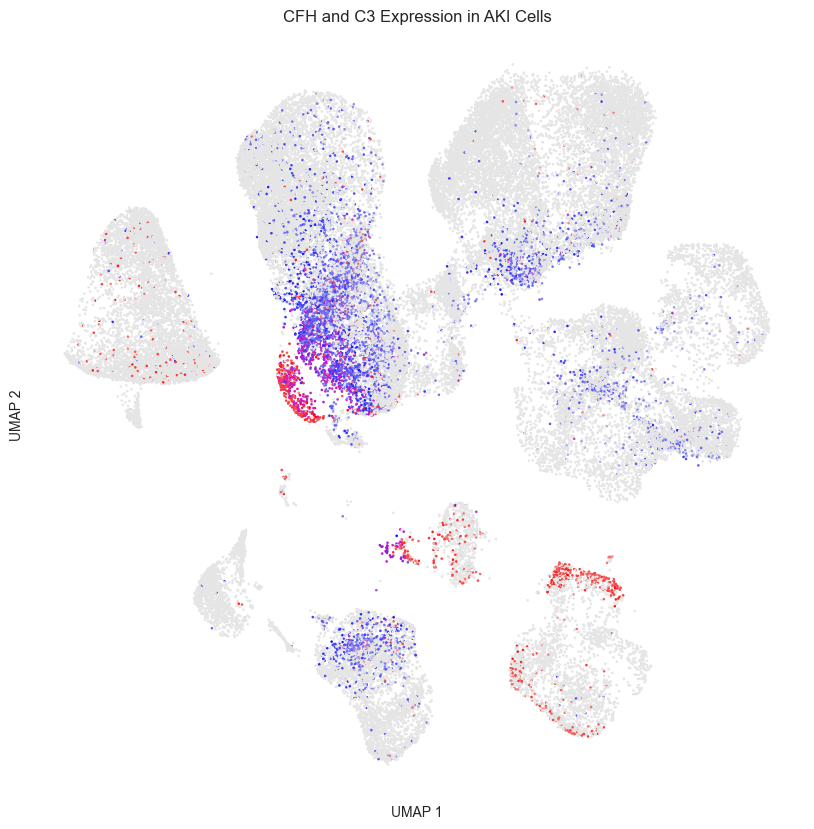

In [6]:
def umap_gene_expression(adata_tot, disease, gene1, gene2, gene_dict, save_path=None):
    """
    Creates a UMAP visualization of two genes' expression patterns across cells with a custom colormap.

    This function filters the data based on the specified disease type before plotting.

    Parameters
    ----------
    adata_tot : AnnData
        Full AnnData object containing single-cell RNA-seq data.
    disease : str
        The disease state to subset (e.g., 'AKI', 'CKD', 'Reference').
    gene1 : str
        Name of the first gene to visualize (mapped to red).
    gene2 : str
        Name of the second gene to visualize (mapped to blue).
    gene_dict : dict
        Dictionary mapping gene names to Ensembl IDs for lookup.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.

    Returns
    -------
    None
    """

    # Subset data based on disease type
    adata = adata_tot[adata_tot.obs['diseasetype'] == disease, :].copy()

    # Fetch Ensembl ID from dictionary or return original gene name
    def get_ensembl_id(gene_name):
        return gene_dict.get(gene_name, gene_name)

    # Extract and flatten gene expression values
    def get_expression(ensembl_id):
        exp = adata[:, ensembl_id].X
        return exp.toarray().ravel() if scipy.sparse.issparse(exp) else exp.ravel()

    # Compute RGB color mapping
    def compute_colors(x_scatter, y_scatter, white_val=0.9):
        w = (1 - x_scatter) * (1 - y_scatter)
        r = x_scatter * (1 - y_scatter)
        b = (1 - x_scatter) * y_scatter
        p = x_scatter * y_scatter
        return np.clip(np.column_stack([
            white_val * w + r + p,  # Red
            white_val * w,          # Green
            white_val * w + b + p   # Blue
        ]), 0, 1)

    # Get Ensembl IDs and expressions for both genes
    gene1_ensembl = get_ensembl_id(gene1)
    gene2_ensembl = get_ensembl_id(gene2)
    g1_vals = get_expression(gene1_ensembl)
    g2_vals = get_expression(gene2_ensembl)

    # Normalize the gene expressions
    g1_scaled = (g1_vals - g1_vals.min()) / (g1_vals.max() - g1_vals.min())
    g2_scaled = (g2_vals - g2_vals.min()) / (g2_vals.max() - g2_vals.min())

    # Compute colors
    scatter_colors = compute_colors(g1_scaled, g2_scaled)

    # Plot setup
    fig, ax_umap = plt.subplots(figsize=(10, 10), facecolor='white')
    ax_umap.set_facecolor('white')

    # Scatter plot
    ax_umap.scatter(
        adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
        c=scatter_colors, s=0.75, alpha=1.0
    )

    ax_umap.set_title(f'{gene1} and {gene2} Expression in {disease} Cells')
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    ax_umap.grid(False)
    ax_umap.set_xticks([])
    ax_umap.set_yticks([])

    # Save or show plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage
umap_gene_expression(adata_tot, "AKI", "CFH", "C3", gene_dict, save_path="AKI_umap_CFHvC3.pdf")
